##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# JAX 上的 TensorFlow Probability

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/probability/examples/TensorFlow_Probability_on_JAX"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/TensorFlow_Probability_on_JAX.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/TensorFlow_Probability_on_JAX.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/TensorFlow_Probability_on_JAX.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

TensorFlow Probability (TFP) 是用于进行概率推理和统计分析的库，现在也可以在 [JAX](https://github.com/google/jax) 上运行！对于不熟悉 JAX 的人来说，JAX 是用于根据可组合的函数转换来加快数值计算的库。

JAX 上的 TFP 支持常规 TFP 中大量极为有用的功能，同时还保留了许多 TFP 用户现在习惯使用的抽象和 API。

## 设置

JAX 上的 TFP **不**依赖于 TensorFlow；我们将 TensorFlow 从本 Colab 中完全卸载！

In [ ]:
!pip uninstall tensorflow -y -q

我们可以使用最新的 Nightly 版本 TFP 在 JAX 上安装 TFP。

In [ ]:
!pip install -Uq tfp-nightly[jax] > /dev/null

我们导入一些有用的 Python 库。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


我们再导入一些基本的 JAX 功能。

In [ ]:
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap

## 在 JAX 上导入 TFP

要在 JAX 上使用 TFP，只需导入 `jax`“基质”，并像平常使用 `tfp` 那样使用该“基质”：

In [ ]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## 演示：贝叶斯逻辑回归

为了演示 JAX 后端的功能，我们将实现应用于经典 Iris 数据集的贝叶斯逻辑回归。

首先，导入 Iris 数据集，并提取一些元数据。


In [ ]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

我们可以使用 `tfd.JointDistributionCoroutine` 定义该模型。我们将标准正态先验应用于权重和偏项，然后编写一个 `target_log_prob` 函数，用于将抽样标签固定到数据。

In [ ]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  w = yield Root(tfd.Sample(tfd.Normal(0., 1.),
                            sample_shape=(num_features, num_classes)))
  b = yield Root(
      tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,)))
  logits = jnp.dot(features, w) + b
  yield tfd.Independent(tfd.Categorical(logits=logits),
                        reinterpreted_batch_ndims=1)


dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
  return dist.log_prob(params + (labels,))

我们从 `dist` 中抽样，为 MCMC 生成初始状态。然后，我们可以定义一个函数，用于接受随机密钥和初始状态，并基于 No-U-Turn-Sampler (NUTS) 生成 500 个样本。请注意，我们可以使用 `jit` 等 JAX 转换通过 XLA 对 NUTS 抽样器进行编译。

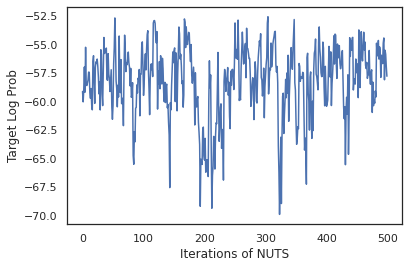

In [ ]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed=init_key)[:-1])

@jit
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
  return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=500,
      seed=key)

states, log_probs = run_chain(sample_key, init_params)
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

我们使用我们的样本对每一组权重的预测概率求平均值，从而执行贝叶斯模型平均 (BMA)。

首先，我们编写一个函数，对于一组给定的参数，该函数将生成每个类的概率。我们可以使用 `dist.sample_distributions` 来获得模型中的最终分布。

In [ ]:
def classifier_probs(params):
  dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                       value=params + (None,))
  return dists[-1].distribution.probs_parameter()

我们可以对这组样本执行 `vmap(classifier_probs)`，从而获得每个样本的预测类概率。之后，我们计算每个样本的平均准确率，以及贝叶斯模型平均的准确率。

In [ ]:
all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.96952
BMA accuracy: 0.97999996


BMA 似乎可以将我们的错误率减少差不多三分之一！

## 基本原理

JAX 上的 TFP 与 TF 具有相同的 API，它接受 JAX 模拟量，而不是 `tf.Tensor` 等 TF 对象。例如，在 `tf.Tensor` 以前用作输入的位置，该 API 现在应该使用 JAX `DeviceArray`。TFP 方法将返回 `DeviceArray`，而不是 `tf.Tensor`。JAX 上的 TFP 也使用 JAX 对象的嵌套结构，例如 `DeviceArray` 列表或字典。


## 分布

TFP 的大多数分布都可以在 JAX 中使用，其语义与 TF 对应项极为类似。这些分布也作为 [JAX Pytree](https://jax.readthedocs.io/en/latest/pytrees.html) 注册，因此可以作为 JAX 转换函数的输入和输出。

### 基本分布

分布的 `log_prob` 方法运行方式相同。

In [ ]:
dist = tfd.Normal(0., 1.)
print(dist.log_prob(0.))

-0.9189385


从分布中抽样时，需要明确传入 `PRNGKey`（或一组整数）作为 `seed` 关键字参数。如果无法明确传入种子，将会引发错误。

In [ ]:
tfd.Normal(0., 1.).sample(seed=random.PRNGKey(0))

DeviceArray(-0.20584226, dtype=float32)

分布的形状语义与在 JAX 中相同，也就是说，每个分布都有一个 `event_shape` 和一个 `batch_shape`，如果绘制多个样本，将会另外增加 `sample_shape` 维度。

例如，使用向量参数的 `tfd.MultivariateNormalDiag` 的事件形状为向量，批次形状为空白。

In [ ]:
dist = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(5),
    scale_diag=jnp.ones(5)
)
print('Event shape:', dist.event_shape)
print('Batch shape:', dist.batch_shape)

Event shape: (5,)
Batch shape: ()


另一方面，使用向量参数化的 `tfd.Normal` 的事件形状为标量，批次形状为向量。

In [ ]:
dist = tfd.Normal(
    loc=jnp.ones(5),
    scale=jnp.ones(5),
)
print('Event shape:', dist.event_shape)
print('Batch shape:', dist.batch_shape)

Event shape: ()
Batch shape: (5,)


用于计算样本 `log_prob` 的语义的运行方式也与在 JAX 中相同。

In [ ]:
dist =  tfd.Normal(jnp.zeros(5), jnp.ones(5))
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

dist =  tfd.Independent(tfd.Normal(jnp.zeros(5), jnp.ones(5)), 1)
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

(10, 2, 5)
(10, 2)


由于 JAX `DeviceArray` 与 NumPy 和 Matplotlib 等库兼容，我们可以直接将样本馈送给绘制函数。

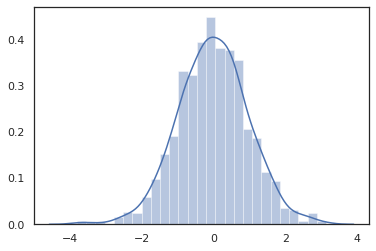

In [ ]:
sns.distplot(tfd.Normal(0., 1.).sample(1000, seed=random.PRNGKey(0)))
plt.show()

`Distribution` 方法与 JAX 转换兼容。

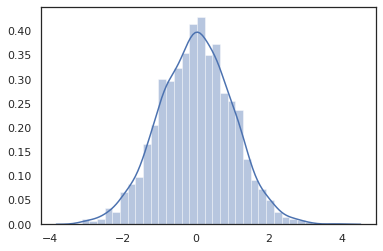

In [ ]:
sns.distplot(jit(vmap(lambda key: tfd.Normal(0., 1.).sample(seed=key)))(
    random.split(random.PRNGKey(0), 2000)))
plt.show()

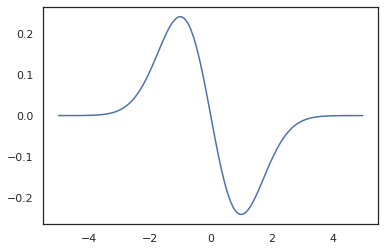

In [ ]:
x = jnp.linspace(-5., 5., 100)
plt.plot(x, jit(vmap(grad(tfd.Normal(0., 1.).prob)))(x))
plt.show()

由于 TFP 分布作为 JAX pytree 节点注册，我们可以编写以分布作为输入或输出的函数，并使用 `jit` 对其进行转换，但还不支持将这些分布作为 `vmap` 函数的参数。

In [ ]:
@jit
def random_distribution(key):
  loc_key, scale_key = random.split(key)
  loc, log_scale = random.normal(loc_key), random.normal(scale_key)
  return tfd.Normal(loc, jnp.exp(log_scale))
random_dist = random_distribution(random.PRNGKey(0))
print(random_dist.mean(), random_dist.variance())

0.14389051 0.081832744


### 转换的分布

转换的分布就是通过 `Bijector` 传递样本的分布，也是立即可供使用（双射函数也可用！请参阅下文）。

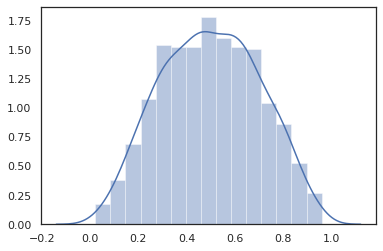

In [ ]:
dist = tfd.TransformedDistribution(
    tfd.Normal(0., 1.),
    tfb.Sigmoid()
)
sns.distplot(dist.sample(1000, seed=random.PRNGKey(0)))
plt.show()

### 联合分布

TFP 提供了 `JointDistribution`，可用于将各个组件分布合并为多个随机变量的单一分布。目前，TFP 提供了三个核心变体（`JointDistributionSequential`、`JointDistributionNamed` 和 `JointDistributionCoroutine`），它们均可以在 JAX 中使用。另外，JAX 也支持 `AutoBatched` 的所有变体。

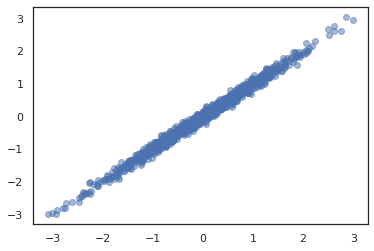

In [ ]:
dist = tfd.JointDistributionSequential([
  tfd.Normal(0., 1.),
  lambda x: tfd.Normal(x, 1e-1)
])
plt.scatter(*dist.sample(1000, seed=random.PRNGKey(0)), alpha=0.5)
plt.show()

In [ ]:
joint = tfd.JointDistributionNamed(dict(
    e=             tfd.Exponential(rate=1.),
    n=             tfd.Normal(loc=0., scale=2.),
    m=lambda n, e: tfd.Normal(loc=n, scale=e),
    x=lambda    m: tfd.Sample(tfd.Bernoulli(logits=m), 12),
))
joint.sample(seed=random.PRNGKey(0))

{'e': DeviceArray(3.376818, dtype=float32),
 'm': DeviceArray(2.5449684, dtype=float32),
 'n': DeviceArray(-0.6027825, dtype=float32),
 'x': DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)}

In [ ]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  e = yield Root(tfd.Exponential(rate=1.))
  n = yield Root(tfd.Normal(loc=0, scale=2.))
  m = yield tfd.Normal(loc=n, scale=e)
  x = yield tfd.Sample(tfd.Bernoulli(logits=m), 12)

joint = tfd.JointDistributionCoroutine(model)

joint.sample(seed=random.PRNGKey(0))

StructTuple(var0=DeviceArray(0.17315261, dtype=float32), var1=DeviceArray(-3.290489, dtype=float32), var2=DeviceArray(-3.1949058, dtype=float32), var3=DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

### 其他分布

高斯过程也可以在 JAX 模式下使用！

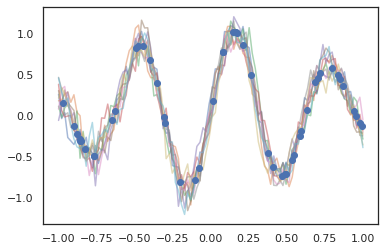

In [ ]:
k1, k2, k3 = random.split(random.PRNGKey(0), 3)
observation_noise_variance = 0.01
f = lambda x: jnp.sin(10*x[..., 0]) * jnp.exp(-x[..., 0]**2)
observation_index_points = random.uniform(
    k1, [50], minval=-1.,maxval= 1.)[..., jnp.newaxis]
observations = f(observation_index_points) + tfd.Normal(
    loc=0., scale=jnp.sqrt(observation_noise_variance)).sample(seed=k2)

index_points = jnp.linspace(-1., 1., 100)[..., jnp.newaxis]

kernel = tfpk.ExponentiatedQuadratic(length_scale=0.1)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10, seed=k3)
for i in range(10):
  plt.plot(index_points, samples[i], alpha=0.5)
plt.plot(observation_index_points, observations, marker='o', linestyle='')
plt.show()

JAX 也支持隐马尔可夫模型。

In [ ]:
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])

observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

print(model.mean())
print(model.log_prob(jnp.zeros(7)))
print(model.sample(seed=random.PRNGKey(0)))

[3.       6.       7.5      8.249999 8.625001 8.812501 8.90625 ]


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/substrates/jax/distributions/hidden_markov_model.py:483: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  'HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug '


-19.855635
[ 1.3641367  0.505798   1.3626463  3.6541772  2.272286  15.10309
 22.794212 ]


JAX 还不支持 `PixelCNN` 等少数几种分布，因为它们严重依赖于 TensorFlow 或者与 XLA 不兼容。

## 双射器

现在，JAX 支持 TFP 的大部分双射器！

In [ ]:
tfb.Exp().inverse(1.)

DeviceArray(0., dtype=float32)

In [ ]:
bij = tfb.Shift(1.)(tfb.Scale(3.))
print(bij.forward(jnp.ones(5)))
print(bij.inverse(jnp.ones(5)))

[4. 4. 4. 4. 4.]
[0. 0. 0. 0. 0.]


In [ ]:
b = tfb.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=None)
print(b.forward(x=[0., 0., 0.]))
print(b.inverse(y=[[1., 0], [.5, 2]]))

[[1. 0.]
 [0. 1.]]
[0.6931472 0.5       0.       ]


In [ ]:
b = tfb.Chain([tfb.Exp(), tfb.Softplus()])
# or:
# b = tfb.Exp()(tfb.Softplus())
print(b.forward(-jnp.ones(5)))

[1.3678794 1.3678794 1.3678794 1.3678794 1.3678794]


双射器与 `jit`、`grad` 和 `vmap` 等 JAX 转换兼容。

In [ ]:
jit(vmap(tfb.Exp().inverse))(jnp.arange(4.))

DeviceArray([     -inf, 0.       , 0.6931472, 1.0986123], dtype=float32)

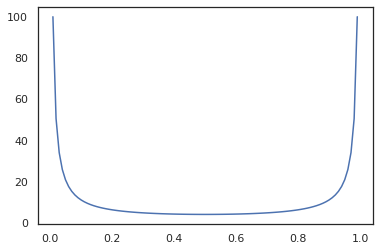

In [ ]:
x = jnp.linspace(0., 1., 100)
plt.plot(x, jit(grad(lambda x: vmap(tfb.Sigmoid().inverse)(x).sum()))(x))
plt.show()

不过，现在还不支持 `RealNVP` 和 `FFJORD` 等部分双射器。

## MCMC

此外，我们还将 `tfp.mcmc` 移植到 JAX 中，因此，可以在 JAX 中运行汉密尔顿蒙特卡洛 (HMC) 和 No-U-Turn-Sampler (NUTS) 等算法。

In [ ]:
target_log_prob = tfd.MultivariateNormalDiag(jnp.zeros(2), jnp.ones(2)).log_prob

与 TF 上的 TFP 不同的是，我们需要使用 `seed` 关键字参数将 `PRNGKey` 传递到 `sample_chain` 中。

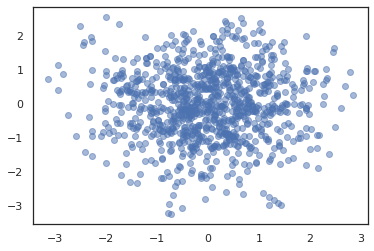

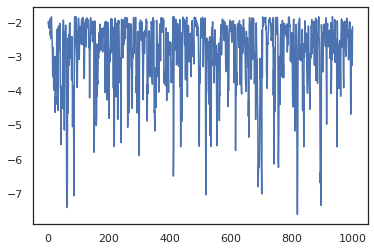

In [ ]:
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-1)
  return tfp.mcmc.sample_chain(1000,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      seed=key)
states, log_probs = jit(run_chain)(random.PRNGKey(0), jnp.zeros(2))
plt.figure()
plt.scatter(*states.T, alpha=0.5)
plt.figure()
plt.plot(log_probs)
plt.show()

为了运行多个链，我们可以将一批状态传递到 `sample_chain` 中，也可以使用 `vmap`（不过我们尚未探索这两种方式在性能方面的差异）。

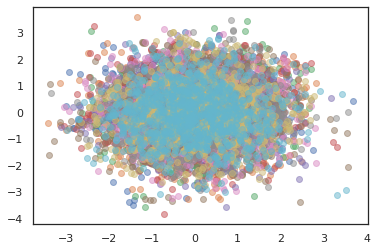

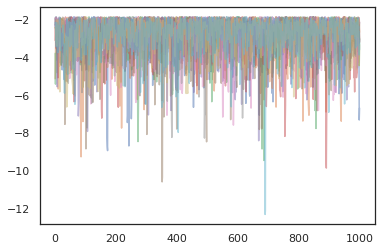

In [ ]:
states, log_probs = jit(run_chain)(random.PRNGKey(0), jnp.zeros([10, 2]))
plt.figure()
for i in range(10):
  plt.scatter(*states[:, i].T, alpha=0.5)
plt.figure()
for i in range(10):
  plt.plot(log_probs[:, i], alpha=0.5)
plt.show()

## 优化器

JAX 上的 TFP 支持一些重要的优化器，例如 BFGS 和 L-BFGS。我们来设置一个简单的定标平方损失函数。

In [ ]:
minimum = jnp.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = jnp.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic_loss(x):
  return jnp.sum(scales * jnp.square(x - minimum))

start = jnp.array([0.6, 0.8])  # Starting point for the search.

BFGS 可以找到此损失的最小值。

In [ ]:
optim_results = tfp.optimizer.bfgs_minimize(
    value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)

Function evaluations: 5


L-BFGS 也可以找到此损失的最小值。

In [ ]:
optim_results = tfp.optimizer.lbfgs_minimize(
    value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)

Function evaluations: 5


为了对 L-BFGS 执行 `vmap`，我们设置一个函数，用于优化单一起始点的损失。

In [ ]:
def optimize_single(start):
  return tfp.optimizer.lbfgs_minimize(
      value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

all_results = jit(vmap(optimize_single))(
    random.normal(random.PRNGKey(0), (10, 2)))
assert all(all_results.converged)
for i in range(10):
  np.testing.assert_allclose(optim_results.position[i], minimum)
print("Function evaluations: %s" % all_results.num_objective_evaluations)

Function evaluations: [6 6 9 6 6 8 6 8 5 9]


## 注意事项

TF 与 JAX 之间存在一些根本区别，有些 TFP 行为在这两种基质之间有所不同，并不是所有功能均受支持。例如，

- JAX 上的 TFP 不支持任何诸如 `tf.Variable` 一类的功能，因为此类功能在 JAX 中不存在。这也意味着 `tfp.util.TransformedVariable` 等实用工具也不受支持。
- 后端现在还不支持 `tfp.layers`，因为它依赖于 Keras 和 `tf.Variable`。
- `tfp.math.minimize` 不适用于 JAX 上的 TFP，因为它依赖于 `tf.Variable`。
- 对于 JAX 上的 TFP，张量形状始终为具体的整数值，从来都是已知值，不像在 TF 上的 TFP 那样会动态变化。
- 在 TF 与 JAX 中，伪随机性的处理方式不同（请参阅附录）。
- 无法确保 `tfp.experimental` 中的库也存在于 JAX 基质中。
- 数据类型提升规则在 TF 与 JAX 之间有所不同。为了保持一致，JAX 上的 TFP 尝试在内部遵守 TF 的数据类型语义。
- 双射器尚未注册为 JAX pytree。

要想查看可以在 JAX 上的 TFP 中使用的全部功能，请参阅 [API 文档](https://tensorflow.google.cn/probability/api_docs/python/tfp/substrates/jax)。

## 结论

我们已将众多 TFP 功能移植到 JAX 中，看到所有人构建的内容，我们感到非常激动。某些功能目前还不能使用；如果我们遗漏了对您来说很重要的内容（或者您发现了错误！），请跟我们联系。您可以发送电子邮件至 [tfprobability@tensorflow.org](mailto:tfprobability@tensorflow.org)，也可以在[我们的 Github 仓库](https://github.com/tensorflow/probability)上提交议题。

## 附录：JAX 中的伪随机性

JAX 的伪随机数生成 (PRNG) 模型*无状态*。有状态模型的全局状态在每次随机绘制后都会发生变化，与有状态模型不同的是，该模型没有可变的全局状态。在 JAX 模型中，我们从 PRNG *密钥*开始，该密钥类似于一对 32 位整数。我们可以使用 `jax.random.PRNGKey` 来构造这些密钥。

In [ ]:
key = random.PRNGKey(0)  # Creates a key with value [0, 0]
print(key)

[0 0]


JAX 中的随机函数使用密钥*确切地*生成随机变量，也就是说，这些变量不应当重复使用。例如，我们可以使用 `key` 对正态分布值抽样，但我们不应当在其他位置再使用 `key`。此外，如果将同一个值传递给 `random.normal`，也会得到相同的值。

In [ ]:
print(random.normal(key))

-0.20584226


那么，我们如何基于一个密钥绘制多个样本？答案就是*密钥拆分*。基本思路是，我们可以将一个 `PRNGKey` 拆分为多个密钥，并将每一个新密钥视为一个独立的随机源。

In [ ]:
key1, key2 = random.split(key, num=2)
print(key1, key2)

[4146024105  967050713] [2718843009 1272950319]


密钥拆分是确定的，但没有顺序，因此，每个新密钥现在均可用于绘制一个不同的随机样本。

In [ ]:
print(random.normal(key1), random.normal(key2))

0.14389051 -1.2515389


有关 JAX 确定性密钥拆分模型的更多详细信息，请参阅[本指南](https://github.com/google/jax/blob/main/design_notes/prng.md)。